In [1]:
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.1.0-posix-seh-rt_v5-rev1\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import gc
%matplotlib inline

C:\Users\Joshua\Anaconda3\lib\site-packages\ipykernel\pylab\config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
C:\Users\Joshua\Anaconda3\lib\site-packages\ipykernel\pylab\config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
C:\Users\Joshua\Anaconda3\lib\site-packages\ipykernel\pylab\config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
C:\Users\Joshua\Anaconda3\lib\site-packages\ipykernel\pylab\config.py:95: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be 

In [3]:
#Reading data into dataframes
print("Reading priors")
order_products_p = pd.read_csv("../instacart_project/order_products__prior.csv",
                               dtype={"order_id":np.int32,
                                      "product_id":np.int32,
                                      "add_to_cart_order":np.int16,
                                      "reordered":np.int8})

print("Reading orders")
orders = pd.read_csv("../instacart_project/orders.csv",
                    dtype={"order_id":np.int32,
                           "user_id":np.int32,
                           "order_number":np.int8,
                           "order_dow":np.int8,
                           "order_hour_of_day":np.int8,
                           "days_since_prior_order":np.float32})

print("Reading products")
products = pd.read_csv("../instacart_project/products.csv",
                       dtype={"product_id":np.int32,
                              "aisle_id":np.int16,
                              "department_id":np.int8},usecols=["product_id","aisle_id","department_id"])

print("Merging orders with priors")
order_products_p = order_products_p.merge(orders,on="order_id",how="inner")

print("Merging products with priors")
order_products_p = order_products_p.merge(products,on="product_id",how="inner")
print("Finished")

Reading priors
Reading orders
Reading products
Merging orders with priors
Merging products with priors
Finished


In [5]:
#User stats
user_stats = pd.DataFrame()

print("Calculating orders by user")
user_stats["orders_user"] = (orders.groupby("user_id").size()).astype(np.int16)

print("Calculating product orders by user")
user_stats["product_orders_user"] = (order_products_p.groupby("user_id").count()["reordered"]).astype(np.int16)

print("Calculating product reorders by user")
user_stats["product_reorders_user"] = (order_products_p.groupby("user_id").sum()["reordered"]).astype(np.int16)

print("Calculating reorder ratio of user")
user_stats["reorder_ratio_user"] = (user_stats["product_reorders_user"]/
                                    user_stats["product_orders_user"]).astype(np.float32)

print("Calculating average days between orders for user")
user_stats["avg_days_between_orders_user"] = (orders.groupby("user_id").mean()["days_since_prior_order"]).astype(np.float32)

print("Calculating unique products ordered by user")
user_stats["unique_products_ordered_user"] = (order_products_p.groupby("user_id")["product_id"].apply(set))

print("Calculating number unique products ordered by user")
user_stats["nb_unique_products_ordered_user"] = (user_stats["unique_products_ordered_user"].apply(len)).astype(np.int32)

print("Calculating unique aisles ordered by user")
user_stats["unique_aisles_ordered_user"] = (order_products_p.groupby("user_id")["aisle_id"].apply(set))

print("Calculating number unique aisles ordered by user")
user_stats["nb_unique_aisles_ordered_user"] = (user_stats["unique_aisles_ordered_user"].apply(len)).astype(np.int16)

print("Calculating unique departments ordered by user")
user_stats["unique_departments_ordered_user"] = (order_products_p.groupby("user_id")["department_id"].apply(set))

print("Calculating number unique departments ordered by user")
user_stats["nb_unique_departments_ordered_user"] = (user_stats["unique_departments_ordered_user"].apply(len)).astype(np.int16)

print("Finished")


Calculating orders by user
Calculating product orders by user
Calculating product reorders by user
Calculating reorder ratio of user
Calculating average days between orders for user
Calculating unique products ordered by user
Calculating number unique products ordered by user
Calculating unique aisles ordered by user
Calculating number unique aisles ordered by user
Calculating unique departments ordered by user
Calculating number unique departments ordered by user
Finished


In [6]:
#Product stats
product_stats = pd.DataFrame()

print("Calculating average add to cart position for product")
product_stats["avg_add_to_cart_position_product"] = (order_products_p.groupby("product_id").mean()["add_to_cart_order"]).astype(np.float32)

print("Calculating product orders for product")
product_stats["product_orders_product"] = (order_products_p.groupby("product_id").count()["reordered"]).astype(np.int32)

print("Calculating product reorders for product")
product_stats["product_reorders_product"] = (order_products_p.groupby("product_id").sum()["reordered"]).astype(np.int32)

print("Calculating reorder ratio for product")
product_stats["reorder_ratio_product"] = (product_stats.product_reorders_product/product_stats.product_orders_product).astype(np.float32)

print("Calculating product market share")
total_product_orders = product_stats["product_reorders_product"].sum()
product_stats["product_market_share"] = (product_stats["product_reorders_product"]/total_product_orders).astype(np.float32).fillna(value=0)

print("Finished")

Calculating average add to cart position for product
Calculating product orders for product
Calculating product reorders for product
Calculating reorder ratio for product
Calculating product market share
Finished


In [7]:
#User product stats
user_product_stats = pd.DataFrame()
rel = ["user_id","product_id"]

print("Calculating reorders of product by user")
user_product_stats["product_reorders_UP"] = (order_products_p.groupby(rel).sum()["reordered"]).astype(np.int16)
user_product_stats.reset_index(inplace=True)

print("Joining order info from user_stats")
user_product_stats["user_orders_UP"] = user_product_stats["user_id"].map(user_stats["orders_user"])

print("Calculating reorder ratio of product by user")
user_product_stats["reorder_ratio_UP"] = (user_product_stats["product_reorders_UP"]/
print("Finished")                                          user_product_stats["user_orders_UP"]).astype(np.float32)

Calculating reorders of product by user
Joining order info from user_stats
Calculating reorder ratio of product by user


In [8]:
#Product reorder count statistics by user
print("Calculating product reorder count statistics by user")
user_stats["mean_product_reorder_count_user"] = user_product_stats.groupby("user_id").mean()["product_reorders_UP"].astype(np.float32)
user_stats["max_product_reorder_count_user"] = user_product_stats.groupby("user_id").max()["product_reorders_UP"].astype(np.int16)
user_stats["median_product_reorder_count_user"] = user_product_stats.groupby("user_id").median()["product_reorders_UP"].astype(np.float32)

#Product reorder ratio statistics by user
print("Calculating product reorder ratio statistics by user")
user_stats["mean_product_reorder_ratio_user"] = user_product_stats.groupby("user_id").mean()["reorder_ratio_UP"].astype(np.float32)
user_stats["max_product_reorder_ratio_user"] = user_product_stats.groupby("user_id").max()["reorder_ratio_UP"].astype(np.float32)
user_stats["median_product_reorder_ratio_user"] = user_product_stats.groupby("user_id").median()["reorder_ratio_UP"].astype(np.float32)
print("Finished")

Calculating product reorder count statistics by user
Calculating product reorder ratio statistics by user


In [9]:
count_ratio_entity_relationship_list = ["aisle_id",
                                        "department_id",
                                        ["user_id","aisle_id"],
                                        ["user_id","department_id"]]
entity_relationship_df_dict = {}

for er in count_ratio_entity_relationship_list:
    df = pd.DataFrame()
    
    if type(er) == str:
        er_ = er.replace("_id","")
        print("Calculating product orders for {0}".format(er_))
        df["product_orders_{0}".format(er_)] = order_products_p.groupby(er).size().astype(np.int32)
        
        print("Calculating product reorders for {0}".format(er_))
        df["product_reorders_{0}".format(er_)] = order_products_p.groupby(er).sum()["reordered"].astype(np.int32)
        
        print("Calculating reorder ratio for {0}".format(er_))
        df["reorder_ratio_{0}".format(er_)] = (df["product_reorders_{0}".format(er_)]/
                                               df["product_orders_{0}".format(er_)]).astype(np.float32)
        
        entity_relationship_df_dict[er] = df
    else:
        er1_ = er[0].replace("_id","")
        er2_ = er[1].replace("_id","")
        
        print("Calculating product order for {0} by {1}".format(er1_,er2_))
        df["product_orders_{0}_{1}".format(er1_,er2_)] = order_products_p.groupby(er).size()
        
        print("Calculating product reorders for {0} by {1}".format(er1_,er2_))
        df["product_reorders_{0}_{1}".format(er1_,er2_)] = order_products_p.groupby(er).sum()["reordered"].astype(np.int32)
        
        print("Calculating reorder ratio for {0} by {1}".format(er1_,er2_))
        df["reorder_ratio_{0}_{1}".format(er1_,er2_)] = (df["product_reorders_{0}_{1}".format(er1_,er2_)]/
                                                          df["product_orders_{0}_{1}".format(er1_,er2_)]).astype(np.float32)
        
        entity_relationship_df_dict[tuple(er)] = df

Calculating product orders for aisle
Calculating product reorders for aisle
Calculating reorder ratio for aisle
Calculating product orders for department
Calculating product reorders for department
Calculating reorder ratio for department
Calculating product order for user by aisle
Calculating product reorders for user by aisle
Calculating reorder ratio for user by aisle
Calculating product order for user by department
Calculating product reorders for user by department
Calculating reorder ratio for user by department


In [10]:
orders.set_index(["order_id"],inplace=True)

temp = pd.DataFrame()

print("Calculating reorder count")
temp["product_reorder_count_by_user_by_order"] = order_products_p.groupby(["user_id","order_id"]).sum()["reordered"]

print("Calculating order count")
temp["product_order_count_by_user_by_order"] = order_products_p.groupby(["user_id","order_id"]).size()

print("Calculating reorder ratio")
temp["product_reorder_ratio_by_user_by_order"] = temp["product_reorder_count_by_user_by_order"]/temp["product_order_count_by_user_by_order"]
temp.reset_index(inplace=True)

print("Mapping order number")
temp["order_number"] = temp["order_id"].map(orders["order_number"])
temp.sort_values(by=["user_id","order_number"],inplace=True)

print("Calculating last to first reorder count ratio")
user_stats["last_to_first_reorder_count_ratio"] = (temp.groupby("user_id").agg({"product_reorder_count_by_user_by_order":lambda x:x.iloc[-1]})/
                                                   temp.groupby("user_id").agg({"product_reorder_count_by_user_by_order":lambda x:x.iloc[1]})) \
                                                   .astype(np.float32).fillna(value=0)

print("Calculating last to first reorder ratio ratio")
user_stats["last_to_first_reorder_ratio_ratio"] = (temp.groupby("user_id").agg({"product_reorder_ratio_by_user_by_order":lambda x:x.iloc[-1]})/
                                                   temp.groupby("user_id").agg({"product_reorder_ratio_by_user_by_order":lambda x:x.iloc[1]})) \
                                                   .astype(np.float32).fillna(value=0)

user_stats["last_to_first_reorder_count_ratio"] = user_stats["last_to_first_reorder_count_ratio"].replace([np.inf, -np.inf], 0)
user_stats["last_to_first_reorder_ratio_ratio"] = user_stats["last_to_first_reorder_ratio_ratio"].replace([np.inf, -np.inf], 0)

del temp

print("Finished")

Calculating reorder count
Calculating order count
Calculating reorder ratio
Mapping order number
Calculating last to first reorder count ratio
Calculating last to first reorder ratio ratio
Finished


In [11]:
#Make train and test datasets

orders.reset_index(inplace=True)
products.set_index("product_id",drop=True,inplace=True)

def make_train_test(train_test):
    users = orders[orders["eval_set"] == train_test]["user_id"].unique()
    dataset = orders[orders["user_id"].isin(users)][["order_id","user_id"]]
    print("dataset %s - orders, users" % (train_test))
    dataset = order_products_p[["order_id","product_id"]].merge(dataset,on="order_id",how="inner")
    dataset.drop(["order_id"],axis="columns",inplace=True)
    print("dataset %s - products, users" % (train_test))
    
    cols = ["order_id","user_id","order_number","order_dow","order_hour_of_day"]
    dataset = dataset.merge(orders[orders["eval_set"]==train_test][cols],on="user_id",how="inner")
    print("dataset %s - products, users, orders, number, dow, hour_of_day" % (train_test))
    
    if train_test == "train":
        order_products_t = pd.read_csv("../instacart_project/order_products__train.csv",
                                       dtype={"order_id":np.int32,
                                              "product_id":np.int32,
                                              "reordered":np.int8},
                                       usecols=["order_id","product_id","reordered"])
        dataset = dataset.merge(order_products_t,on=["order_id","product_id"],how="left")
        print("dataset train added labels")
        del order_products_t
        dataset["reordered"].fillna(0,inplace=True)
        dataset["reordered"] = dataset["reordered"].astype(np.int8)
    
    dataset.drop_duplicates(subset=["order_id","product_id"],inplace=True)
    
    product_cols = ["aisle_id","department_id"]
    for c in product_cols:
        dataset[c] = dataset["product_id"].map(products[c])
    print("dataset %s - products, users, orders, number, dow, hour_of_day, aisle, dept" % (train_test))
    
    return dataset

train = make_train_test("train")
test = make_train_test("test")
del products, orders, order_products_p
cols = ["order_number","order_dow","order_hour_of_day","aisle_id","department_id"]
print("Finished")

dataset train - orders, users
dataset train - products, users
dataset train - products, users, orders, number, dow, hour_of_day
dataset train added labels
dataset train - products, users, orders, number, dow, hour_of_day, aisle, dept
dataset test - orders, users
dataset test - products, users
dataset test - products, users, orders, number, dow, hour_of_day
dataset test - products, users, orders, number, dow, hour_of_day, aisle, dept
Finished


In [12]:
for c in user_stats.columns:
    train[c] = train["user_id"].map(user_stats[c])
    test[c] = test["user_id"].map(user_stats[c])
    
for c in product_stats.columns:
    train[c] = train["product_id"].map(product_stats[c])
    test[c] = test["product_id"].map(product_stats[c])
    
for c in entity_relationship_df_dict["aisle_id"].columns:
    train[c] = train["aisle_id"].map(entity_relationship_df_dict["aisle_id"][c])
    test[c] = test["aisle_id"].map(entity_relationship_df_dict["aisle_id"][c])
    
for c in entity_relationship_df_dict["department_id"].columns:
    train[c] = train["department_id"].map(entity_relationship_df_dict["department_id"][c])
    test[c] = test["department_id"].map(entity_relationship_df_dict["department_id"][c])

In [13]:
print("Joining user product stats")
train = train.merge(user_product_stats,on=["user_id","product_id"],how="inner")
test = test.merge(user_product_stats,on=["user_id","product_id"],how="inner")

print("Joining user aisle stats")
entity_relationship_df_dict[("user_id","aisle_id")].reset_index(inplace=True)
train = train.merge(entity_relationship_df_dict[("user_id","aisle_id")],on=["user_id","aisle_id"],how="inner")
test = test.merge(entity_relationship_df_dict[("user_id","aisle_id")],on=["user_id","aisle_id"],how="inner")

print("Joining user department stats")
entity_relationship_df_dict[("user_id","department_id")].reset_index(inplace=True)
train = train.merge(entity_relationship_df_dict[("user_id","department_id")],on=["user_id","department_id"],how="inner")
test = test.merge(entity_relationship_df_dict[("user_id","department_id")],on=["user_id","department_id"],how="inner")

Joining user product stats
Joining user aisle stats
Joining user department stats


In [13]:
cols = train.columns.values.tolist()[3:]

cols.remove("unique_products_ordered_user")
cols.remove("unique_aisles_ordered_user")
cols.remove("unique_departments_ordered_user")
cols.remove("reordered")

In [14]:
del user_stats, product_stats, user_product_stats, entity_relationship_df_dict
gc.collect()

C:\Users\Joshua\Anaconda3\lib\site-packages\IPython\core\formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
C:\Users\Joshua\Anaconda3\lib\site-packages\IPython\core\formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


11880

In [16]:
model = xgb.XGBClassifier(max_depth = 7, n_estimators=100, n_jobs=-1, random_state=1)

In [18]:
#cols = ["reorder_ratio_UP","reorder_ratio_product","avg_add_to_cart_position_product","product_reorders_product",
#        "product_orders_product","avg_days_between_orders_user","product_reorders_UP","mean_product_reorder_ratio_user",
#        "product_market_share","reorder_ratio_user_aisle","reorder_ratio_user_department","product_orders_user"]
cols = ["reorder_ratio_UP","reorder_ratio_product","avg_add_to_cart_position_product","product_reorders_product",
        "product_orders_product","avg_days_between_orders_user","product_reorders_UP","mean_product_reorder_ratio_user",
        "product_market_share","reorder_ratio_user_aisle","reorder_ratio_user_department","product_orders_user","order_number"]
model.fit(train[cols],train["reordered"])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [19]:
preds = model.predict_proba(test[cols])

In [22]:
preds_bool = [True if x >= 0.22 else False for x in preds[:,1]]
test_order_id = test["order_id"].unique()
submission = pd.DataFrame()
submission["products"] = test[preds_bool].groupby("order_id")["product_id"].apply(list)
submission["products"] = submission["products"].apply(lambda x:" ".join([str(y) for y in x]))
test_order_id = np.setdiff1d(test_order_id,submission.index.values)
submission = pd.concat(objs = [submission,
                               pd.DataFrame(data = ["None"]*len(test_order_id),
                                            index = test_order_id,
                                            columns = ["products"])])

submission.reset_index(inplace=True)
submission.rename(columns={"index":"order_id"},inplace=True)
submission.to_csv("../instacart_project/submission.csv",index=False)

In [ ]:
cols = train.columns.values.tolist()[3:]

cols.remove("unique_products_ordered_user")
cols.remove("unique_aisles_ordered_user")
cols.remove("unique_departments_ordered_user")
cols.remove("reordered")

scores = cross_val_score(estimator = model, X = train[cols], y = train["reordered"], scoring="f1", cv = 2, n_jobs=-1)
print(scores.mean())

In [25]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

for x in indices:
    print(cols[x], ":", importances[x])
    
cols = ["reorder_ratio_UP","order_number","reorder_ratio_product"]

reorder_ratio_UP : 0.757143
order_number : 0.142857
reorder_ratio_product : 0.1
avg_days_between_orders_user : 0.0
mean_product_reorder_ratio_user : 0.0
median_product_reorder_count_user : 0.0
max_product_reorder_count_user : 0.0
mean_product_reorder_count_user : 0.0
nb_unique_departments_ordered_user : 0.0
nb_unique_aisles_ordered_user : 0.0
nb_unique_products_ordered_user : 0.0
reorder_ratio_user : 0.0
median_product_reorder_ratio_user : 0.0
product_reorders_user : 0.0
product_orders_user : 0.0
orders_user : 0.0
department_id : 0.0
aisle_id : 0.0
order_hour_of_day : 0.0
order_dow : 0.0
max_product_reorder_ratio_user : 0.0
reorder_ratio_user_department : 0.0
last_to_first_reorder_count_ratio : 0.0
product_reorders_department : 0.0
product_orders_user_department : 0.0
reorder_ratio_user_aisle : 0.0
product_reorders_user_aisle : 0.0
product_orders_user_aisle : 0.0
user_orders_UP : 0.0
product_reorders_UP : 0.0
reorder_ratio_department : 0.0
product_orders_department : 0.0
product_reorde

Optimal threshold is between 0.3 and 0.35

In [22]:
preds_bool = [True if x >= 0.35 else False for x in preds[:,1]]
test_order_id = test["order_id"].unique()
submission = pd.DataFrame()
submission["products"] = test[preds_bool].groupby("order_id")["product_id"].apply(list)
submission["products"] = submission["products"].apply(lambda x:" ".join([str(y) for y in x]))
test_order_id = np.setdiff1d(test_order_id,submission.index.values)
submission = pd.concat(objs = [submission,
                               pd.DataFrame(data = ["None"]*len(test_order_id),
                                            index = test_order_id,
                                            columns = ["products"])])

submission.reset_index(inplace=True)
submission.rename(columns={"index":"order_id"},inplace=True)
submission.to_csv("../instacart_project/submission.csv",index=False)

In [20]:
train.head(10)

,product_id,user_id,order_id,order_number,order_dow,order_hour_of_day,reordered,aisle_id,department_id,orders_user,...,reorder_ratio_department,product_reorders_UP,user_orders_UP,reorder_ratio_UP,product_orders_user_aisle,product_reorders_user_aisle,reorder_ratio_user_aisle,product_orders_user_department,product_reorders_user_department,reorder_ratio_user_department
0,33120,202279,1050357,9,1,14,1,86,16,9,...,0.669969,4,9,0.444444,6,4,0.666667,11,6,0.545455
1,14218,202279,1050357,9,1,14,0,86,16,9,...,0.669969,0,9,0.000000,6,4,0.666667,11,6,0.545455
2,12545,202279,1050357,9,1,14,0,91,16,9,...,0.669969,2,9,0.222222,4,2,0.500000,11,6,0.545455
3,432,202279,1050357,9,1,14,0,91,16,9,...,0.669969,0,9,0.000000,4,2,0.500000,11,6,0.545455
4,27531,202279,1050357,9,1,14,0,53,16,9,...,0.669969,0,9,0.000000,1,0,0.000000,11,6,0.545455
5,28985,202279,1050357,9,1,14,0,83,4,9,...,0.649913,4,9,0.444444,13,10,0.769231,20,14,0.700000
6,17794,202279,1050357,9,1,14,0,83,4,9,...,0.649913,6,9,0.666667,13,10,0.769231,20,14,0.700000
7,24933,202279,1050357,9,1,14,0,83,4,9,...,0.649913,0,9,0.000000,13,10,0.769231,20,14,0.700000
8,43668,202279,1050357,9,1,14,0,123,4,9,...,0.649913,2,9,0.222222,7,4,0.571429,20,14,0.700000
9,35106,202279,1050357,9,1,14,0,123,4,9,...,0.649913,2,9,0.222222,7,4,0.571429,20,14,0.700000


In [15]:
rfc = RandomForestClassifier(n_estimators = 10, n_jobs = -1, random_state=1)
rfc.fit(train[cols],train["reordered"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=1,
            verbose=0, warm_start=False)

In [17]:
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
print(indices)

for x in indices:
    print(cols[x], ":", importances[x])

cols = ["reorder_ratio_UP","reorder_ratio_product","avg_add_to_cart_position_product","product_reorders_product",
        "product_orders_product","avg_days_between_orders_user","product_reorders_UP","mean_product_reorder_ratio_user",
        "product_market_share","reorder_ratio_user_aisle","reorder_ratio_user_department","product_orders_user","order_num"]

[34 24 21 23 22  9 32 16 25 37 40  6  8 13 20 10 38 11 19  7  2 39 35 17 12
 28 36  1  3 14 26  5 27  0 33 31  4 18 29 30 15]
reorder_ratio_UP : 0.077573601533
reorder_ratio_product : 0.0440669855223
avg_add_to_cart_position_product : 0.0397655580433
product_reorders_product : 0.0363216545742
product_orders_product : 0.0362968306693
avg_days_between_orders_user : 0.03570513132
product_reorders_UP : 0.0356622608967
mean_product_reorder_ratio_user : 0.0349693343296
product_market_share : 0.0347450854198
reorder_ratio_user_aisle : 0.0333728725634
reorder_ratio_user_department : 0.0304211012946
product_orders_user : 0.0303088376667
reorder_ratio_user : 0.0296858287389
mean_product_reorder_count_user : 0.0296509036122
last_to_first_reorder_ratio_ratio : 0.0290696467059
nb_unique_products_ordered_user : 0.0285922480088
product_orders_user_department : 0.0270918177038
nb_unique_aisles_ordered_user : 0.026693595866
last_to_first_reorder_count_ratio : 0.0264694495986
product_reorders_user : 0.0

In [32]:
cols_to_analyse = [["order_number","order_dow","order_hour_of_day","aisle_id","department_id"],
                   ["avg_days_between_orders_user"],
                   ["nb_unique_products_ordered_user","nb_unique_aisles_ordered_user","nb_unique_departments_ordered_user"],
                   ["avg_add_to_cart_position_product","product_orders_product","product_reorders_product","reorder_ratio_product","product_market_share"],
                   ["mean_product_reorder_count_user","max_product_reorder_count_user","median_product_reorder_count_user","mean_product_reorder_ratio_user","max_product_reorder_ratio_user","median_product_reorder_ratio_user"],
                   ["last_to_first_reorder_count_ratio","last_to_first_reorder_ratio_ratio"],
                   ["product_orders_aisle","product_reorders_aisle","reorder_ratio_aisle"],
                   ["product_orders_department","product_reorders_department","reorder_ratio_department"],
                   ["product_reorders_UP","user_orders_UP","reorder_ratio_UP"],
                   ['product_orders_user_aisle','product_reorders_user_aisle','reorder_ratio_user_aisle]'],
                   ['product_orders_user_department','product_reorders_user_department','reorder_ratio_user_department]']]

In [34]:
for c in cols_to_analyse:
    scores = cross_val_score(estimator = rfc, X = train[c], y = train["reordered"], scoring="f1", n_jobs=-1)
    print(c, "\n\nCV Score: ",scores.mean())

['order_number', 'order_dow', 'order_hour_of_day', 'aisle_id', 'department_id'] 

CV Score:  0.0227366434493
['avg_days_between_orders_user'] 

CV Score:  0.00350327689559
['nb_unique_products_ordered_user', 'nb_unique_aisles_ordered_user', 'nb_unique_departments_ordered_user'] 

CV Score:  0.0210828194619
['avg_add_to_cart_position_product', 'product_orders_product', 'product_reorders_product', 'reorder_ratio_product', 'product_market_share'] 

CV Score:  0.000552292037527
['mean_product_reorder_count_user', 'max_product_reorder_count_user', 'median_product_reorder_count_user', 'mean_product_reorder_ratio_user', 'max_product_reorder_ratio_user', 'median_product_reorder_ratio_user'] 

CV Score:  0.0309586189096
['last_to_first_reorder_count_ratio', 'last_to_first_reorder_ratio_ratio'] 

CV Score:  0.0174032912203
['product_orders_aisle', 'product_reorders_aisle', 'reorder_ratio_aisle'] 

CV Score:  0.0
['product_orders_department', 'product_reorders_department', 'reorder_ratio_departme

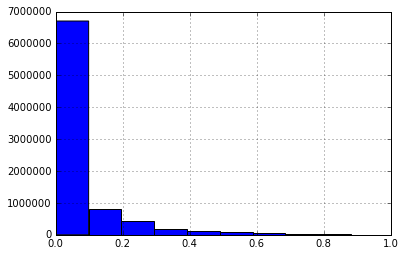

In [35]:
train.reorder_ratio_UP.hist(bins=10)

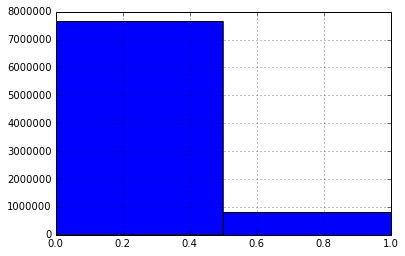

In [37]:
train.reordered.hist(bins=2)

In [3]:
UP_stats = pd.DataFrame()
UP_stats["reordered_ratio"] = order_products_p.groupby(["user_id","product_id"]).mean()["reordered"]

In [4]:
UP_stats["reordered_ratio"].value_counts()

0.000000    7982695
0.500000    2204600
0.666667    1029149
0.750000     579462
0.800000     364763
0.833333     248853
0.857143     178054
0.875000     132073
0.888889     100651
0.900000      78834
0.909091      62830
0.916667      50505
0.923077      41755
0.928571      34358
0.933333      28494
0.937500      24305
0.941176      20476
0.944444      17563
0.947368      15121
0.950000      12875
0.952381      11174
0.954545       9815
0.956522       8540
0.958333       7523
0.960000       6650
0.961538       6063
0.962963       5302
0.964286       4693
0.965517       4149
0.966667       3687
             ...   
0.986301         61
0.985507         60
0.986111         50
0.985915         48
0.986486         40
0.987342         33
0.986667         33
0.987500         29
0.986842         28
0.988095         24
0.987654         24
0.987179         21
0.987013         20
0.987805         17
0.987952         16
0.988372         15
0.988764         13
0.989130         12
0.988636         11


In [ ]:
UP_stats["reordered_ratio"].hist(bins=10)